In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats

In [3]:
def set_style():
    #function for matplotlib formatting
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

# ST, areas >150

In [77]:
bestparams = pd.read_csv("/home/slu/spatial/data/hyperparamCV_lasso/ST_bestparams_032421.csv", sep=',')
bestparams = bestparams.set_index(bestparams.columns)
bestscore = pd.read_csv("/home/slu/spatial/data/hyperparamCV_lasso/ST_bestscore_032421.csv")
meantestscore = np.load('/home/slu/spatial/data/hyperparamCV_lasso/ST_meantestscore_032421.npy',allow_pickle='TRUE').item()
teststd = np.load('/home/slu/spatial/data/hyperparamCV_lasso/ST_meanteststd_032421.npy',allow_pickle='TRUE').item()

In [78]:
bestparams.head()

,632,629,733,9,26,194,943,504,1093,962,...,1111,258,672,806,1090,155,262,952,284,276
632,0,0.01,0.01,0.01,0.01,0.05,0.01,0.01,0.01,0.01,...,0.01,0.05,0.05,0.01,0.05,0.05,0.01,0.10,0.01,0.10
629,0,0.00,0.10,0.01,0.01,0.10,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.05,0.05,0.01,0.01,0.05
733,0,0.00,0.00,0.01,0.01,0.05,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.10,0.20,0.01,0.01,0.01
9,0,0.00,0.00,0.00,0.01,0.01,0.05,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.05,0.01,0.01
26,0,0.00,0.00,0.00,0.00,0.05,0.01,0.01,0.05,0.01,...,0.01,0.01,0.05,0.01,0.01,0.05,0.05,0.01,0.01,0.01


Text(0, 0.5, 'number of brain area\ncomparisons')

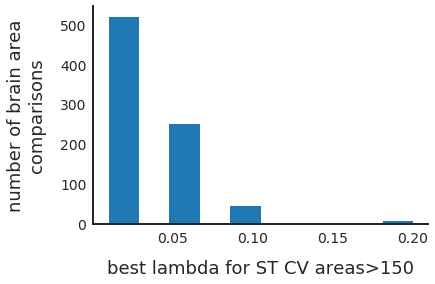

In [5]:
histdata = bestparams.values[np.triu_indices_from(bestparams,k=1)]
#uniq, counts = np.unique(histdata, return_counts=True)
#plt.bar(x=uniq, height=counts)
plt.hist(histdata)
plt.xlabel("best lambda for ST CV areas>150")
plt.ylabel("number of brain area\ncomparisons")
#plt.savefig('032421_1.pdf', bbox_inches='tight')

In [6]:
meantestscore['0,1']

array([1. , 1. , 1. , 1. , 0.5, 0.5])

basically a really circuitous way to get number of samples below cells

In [79]:
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v1.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"

In [80]:
def read_data():
    """read in all datasets needed using pandas"""
    STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
    STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
    STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')

    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return STspotsmeta, STspots, STpropont, ontology

def filterproponto(sampleonto):
    """pre-processing for propogated ontology"""
    #remove brain areas that don't have any samples
    sampleonto_sums = sampleonto.apply(lambda col: col.sum(), axis=0)
    sampleonto = sampleonto.loc[:,sampleonto_sums > 5] #greater than 5 becuase less is not enough for train/test split to have non-zero areas
    
    return sampleonto

def getleaves(propontvox, ontology):
    #leaves are brain areas in the ontology that never show up in the parent column
    allareas = list(propontvox)
    parents = list(ontology.parent)
    for i in range(len(parents)): #convert parents from float to int, ids are ints
        parents[i] = int(parents[i])
    
    #remove parents from all areas
    leaves = []
    for area in allareas:
        if int(area) not in parents:
            leaves.append(area)
    
    return leaves

In [81]:
#pre-processing
STspotsmeta, STspots, STpropont, ontology = read_data()
STpropont = filterproponto(STpropont)
STspots = STspots.astype('float64') #convert int to float for z-scoring
#get leaf areas
leaves = getleaves(STpropont, ontology)
leafSTpropont = STpropont.loc[STspotsmeta.id.isin(leaves),leaves] #subset prop onto for leaf areas
leafSTspots = STspots.loc[STspotsmeta.id.isin(leaves),:] #subset data for samples from leaves

#subset for sufficient samples size for hyperparameter selection
leafsizes = leafSTpropont.sum()
#filter propogated ontology for brain areas with X number of samples min
leafsizes_sub = leafsizes[leafsizes>150]
leafSTpropont_sub = leafSTpropont.loc[:,leafsizes_sub.index]
#remove areas (rows) from propogated ontology that don't have any samples
rowsum = leafSTpropont_sub.sum(axis=1)
leafSTpropont_sub = leafSTpropont_sub.loc[rowsum > 0, :]
#index samples for rows to match porp ont
leafSTspots_sub = leafSTspots.loc[rowsum > 0, :]

In [82]:
numsamples = pd.DataFrame(index=list(bestparams), columns=list(bestparams))
numsamples = numsamples.fillna(0)

areas = list(bestparams)
#for each column, brain area
for i in range(bestparams.shape[1]):
    #for each row in each column
    for j in range(i+1,bestparams.shape[1]): #upper triangular!
        area1 = areas[i]
        area2 = areas[j]
        numsamples.iloc[i,j] = leafsizes[area1] + leafsizes[area2]

In [83]:
numsamples.head()

,632,629,733,9,26,194,943,504,1093,962,...,1111,258,672,806,1090,155,262,952,284,276
632,0,332.0,354.0,318.0,315.0,616.0,449.0,315.0,748.0,374.0,...,368.0,350.0,2202.0,319.0,327.0,320.0,337.0,340.0,432.0,528.0
629,0,0.0,384.0,348.0,345.0,646.0,479.0,345.0,778.0,404.0,...,398.0,380.0,2232.0,349.0,357.0,350.0,367.0,370.0,462.0,558.0
733,0,0.0,0.0,370.0,367.0,668.0,501.0,367.0,800.0,426.0,...,420.0,402.0,2254.0,371.0,379.0,372.0,389.0,392.0,484.0,580.0
9,0,0.0,0.0,0.0,331.0,632.0,465.0,331.0,764.0,390.0,...,384.0,366.0,2218.0,335.0,343.0,336.0,353.0,356.0,448.0,544.0
26,0,0.0,0.0,0.0,0.0,629.0,462.0,328.0,761.0,387.0,...,381.0,363.0,2215.0,332.0,340.0,333.0,350.0,353.0,445.0,541.0


In [84]:
numsamples = numsamples.values[np.triu_indices_from(numsamples,k=1)]

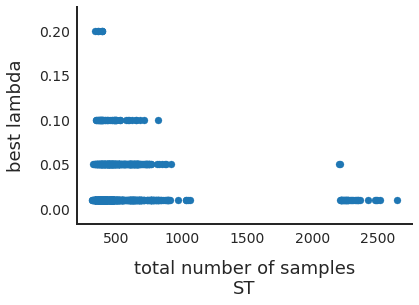

In [13]:
#alpha as a function of brain area size
plt.scatter(numsamples,histdata)
plt.xlabel("total number of samples\nST")
plt.ylabel("best lambda")
#plt.savefig('032421_2.pdf', bbox_inches='tight')
plt.show()

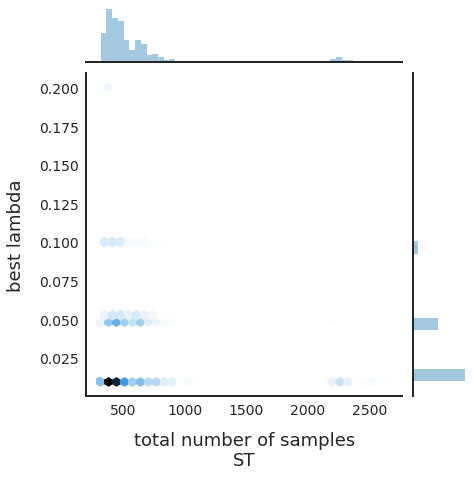

In [14]:
sns.jointplot(numsamples, histdata, kind='hex').set_axis_labels("total number of samples\nST","best lambda")
#plt.savefig('032421_3.pdf', bbox_inches='tight')

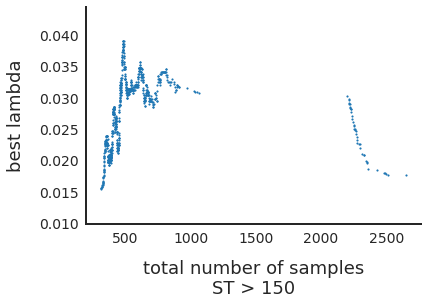

In [26]:
#define 'sliding window' as a uniform dist
uniform = [1/100] * 100
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]
#convolve
hyperp_conv = np.convolve(hyperp_sorted, uniform, mode='same')

plt.scatter(numsamples_sorted, hyperp_conv, s=3, rasterized=True)
plt.xlabel("total number of samples\nST > 150")
plt.ylabel("best lambda")
plt.savefig("033121_1.pdf", bbox_inches='tight')
plt.show()

20


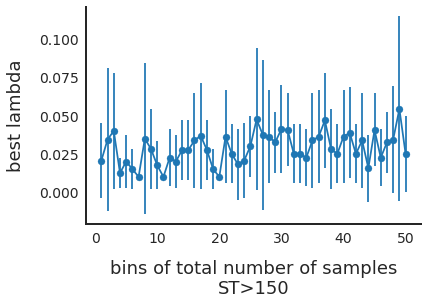

In [30]:
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]

#bin by equal #samples per bin
numbins = 50
binsize = len(numsamples_sorted)//numbins
print(len(numsamples_sorted)%numbins)
mean = []
sd = []
startindex = 0
for i in range(numbins):
    if i == numbins-1: #last bin
        currint = hyperp_sorted[startindex:len(hyperp_sorted)]
    else:
        currint = hyperp_sorted[startindex:startindex+binsize]

    mean.append(np.mean(currint))
    sd.append(np.std(currint))
    startindex = startindex+binsize

plt.scatter(range(1,numbins+1), mean, rasterized=True)
plt.errorbar(x=range(1,numbins+1), y=mean, yerr=sd)
plt.xlabel("bins of total number of samples\nST>150")
plt.ylabel("best lambda")
plt.savefig("033121_2.pdf", bbox_inches='tight')

looking into ties

In [85]:
lastofties = pd.DataFrame(index=list(bestparams), columns=list(bestparams))
lastofties = lastofties.fillna(0)

alphas = [0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
#for each column, brain area
for i in range(bestparams.shape[1]):
    #for each row in each column
    for j in range(i+1,bestparams.shape[1]): #upper triangular!
        currkey = "%d,%d" %(i,j)
        currscores = meantestscore[currkey]
        bestindex = 0
        bestscore = -1
        for k in range(len(currscores)):
            if currscores[k] >= bestscore:
                bestscore = currscores[k]
                bestindex = k
        lastofties.iloc[i,j] = alphas[bestindex]


In [86]:
histdata = lastofties.values[np.triu_indices_from(lastofties,k=1)]

0


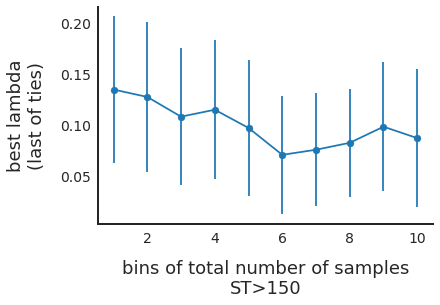

In [88]:
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]

#bin by equal #samples per bin
numbins = 10
binsize = len(numsamples_sorted)//numbins
print(len(numsamples_sorted)%numbins)
mean = []
sd = []
startindex = 0
for i in range(numbins):
    if i == numbins-1: #last bin
        currint = hyperp_sorted[startindex:len(hyperp_sorted)]
    else:
        currint = hyperp_sorted[startindex:startindex+binsize]

    mean.append(np.mean(currint))
    sd.append(np.std(currint))
    startindex = startindex+binsize

plt.scatter(range(1,numbins+1), mean)
plt.errorbar(x=range(1,numbins+1), y=mean, yerr=sd)
plt.xlabel("bins of total number of samples\nST>150")
plt.ylabel("best lambda\n(last of ties)")
plt.savefig("040121_1.pdf", bbox_inches='tight')

# ST, areas >100

In [4]:
bestparams = pd.read_csv("/home/slu/spatial/data/hyperparamCV_lasso/ST_bestparams_032521.csv", sep=',')
bestparams = bestparams.set_index(bestparams.columns)
bestscore = pd.read_csv("/home/slu/spatial/data/hyperparamCV_lasso/ST_bestscore_032521.csv")
meantestscore = np.load('/home/slu/spatial/data/hyperparamCV_lasso/ST_meantestscore_032521.npy',allow_pickle='TRUE').item()
teststd = np.load('/home/slu/spatial/data/hyperparamCV_lasso/ST_meanteststd_032521.npy',allow_pickle='TRUE').item()

In [5]:
bestparams.head()
bestparams.shape

(65, 65)

Text(0, 0.5, 'number of brain area\ncomparisons')

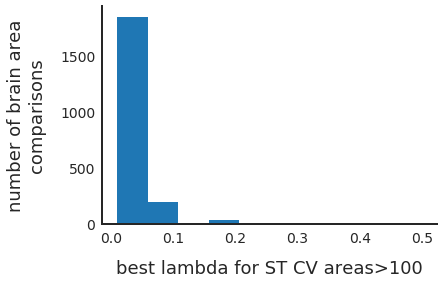

In [33]:
histdata = bestparams.values[np.triu_indices_from(bestparams,k=1)]
#uniq, counts = np.unique(histdata, return_counts=True)
#plt.bar(x=uniq, height=counts)
plt.hist(histdata)
plt.xlabel("best lambda for ST CV areas>100")
plt.ylabel("number of brain area\ncomparisons")
#plt.savefig('032621_1.pdf', bbox_inches='tight')

In [80]:
#meantestscore

get num samples

In [91]:
#pre-processing
STspotsmeta, STspots, STpropont, ontology = read_data()
STpropont = filterproponto(STpropont)
STspots = STspots.astype('float64') #convert int to float for z-scoring
#get leaf areas
leaves = getleaves(STpropont, ontology)
leafSTpropont = STpropont.loc[STspotsmeta.id.isin(leaves),leaves] #subset prop onto for leaf areas
leafSTspots = STspots.loc[STspotsmeta.id.isin(leaves),:] #subset data for samples from leaves

#subset for sufficient samples size for hyperparameter selection
leafsizes = leafSTpropont.sum()
#filter propogated ontology for brain areas with X number of samples min
leafsizes_sub = leafsizes[leafsizes>100]
leafSTpropont_sub = leafSTpropont.loc[:,leafsizes_sub.index]
#remove areas (rows) from propogated ontology that don't have any samples
rowsum = leafSTpropont_sub.sum(axis=1)
leafSTpropont_sub = leafSTpropont_sub.loc[rowsum > 0, :]
#index samples for rows to match porp ont
leafSTspots_sub = leafSTspots.loc[rowsum > 0, :]

In [92]:
numsamples = pd.DataFrame(index=list(bestparams), columns=list(bestparams))
numsamples = numsamples.fillna(0)

areas = list(bestparams)
#for each column, brain area
for i in range(bestparams.shape[1]):
    #for each row in each column
    for j in range(i+1,bestparams.shape[1]): #upper triangular!
        area1 = areas[i]
        area2 = areas[j]
        numsamples.iloc[i,j] = leafsizes[area1] + leafsizes[area2]

In [93]:
numsamples = numsamples.values[np.triu_indices_from(numsamples,k=1)]

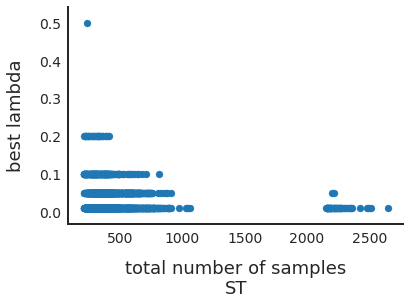

In [40]:
#alpha as a function of brain area size
plt.scatter(numsamples,histdata)
plt.xlabel("total number of samples\nST")
plt.ylabel("best lambda")
plt.savefig('032621_2.pdf', bbox_inches='tight')
plt.show()

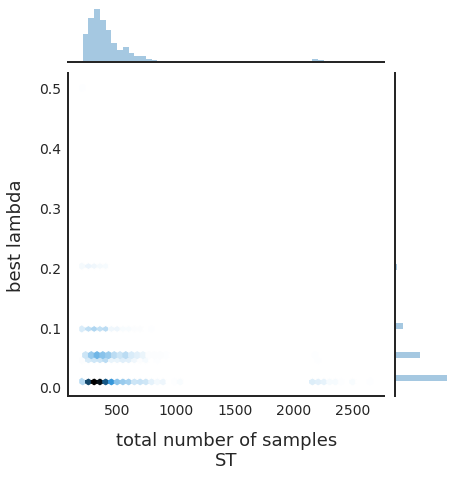

In [41]:
sns.jointplot(numsamples, histdata, kind='hex').set_axis_labels("total number of samples\nST","best lambda")
plt.savefig('032621_3.pdf', bbox_inches='tight')

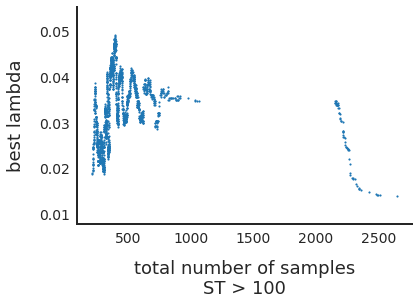

In [43]:
#define 'sliding window' as a uniform dist
uniform = [1/100] * 100
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]
#convolve
hyperp_conv = np.convolve(hyperp_sorted, uniform, mode='same')

plt.scatter(numsamples_sorted, hyperp_conv, s=3, rasterized=True)
plt.xlabel("total number of samples\nST > 100")
plt.ylabel("best lambda")
plt.savefig("033121_3.pdf", bbox_inches='tight')
plt.show()

30


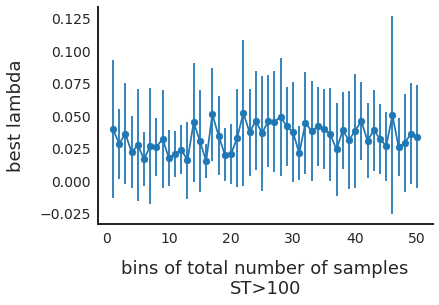

In [44]:
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]

#bin by equal #samples per bin
numbins = 50
binsize = len(numsamples_sorted)//numbins
print(len(numsamples_sorted)%numbins)
mean = []
sd = []
startindex = 0
for i in range(numbins):
    if i == numbins-1: #last bin
        currint = hyperp_sorted[startindex:len(hyperp_sorted)]
    else:
        currint = hyperp_sorted[startindex:startindex+binsize]

    mean.append(np.mean(currint))
    sd.append(np.std(currint))
    startindex = startindex+binsize

plt.scatter(range(1,numbins+1), mean, rasterized=True)
plt.errorbar(x=range(1,numbins+1), y=mean, yerr=sd)
plt.xlabel("bins of total number of samples\nST>100")
plt.ylabel("best lambda")
plt.savefig("033121_4.pdf", bbox_inches='tight')

looking into ties

In [94]:
lastofties = pd.DataFrame(index=list(bestparams), columns=list(bestparams))
lastofties = lastofties.fillna(0)

alphas = [0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
#for each column, brain area
for i in range(bestparams.shape[1]):
    #for each row in each column
    for j in range(i+1,bestparams.shape[1]): #upper triangular!
        currkey = "%d,%d" %(i,j)
        currscores = meantestscore[currkey]
        bestindex = 0
        bestscore = -1
        for k in range(len(currscores)):
            if currscores[k] >= bestscore:
                bestscore = currscores[k]
                bestindex = k
        lastofties.iloc[i,j] = alphas[bestindex]

In [95]:
histdata = lastofties.values[np.triu_indices_from(lastofties,k=1)]

0


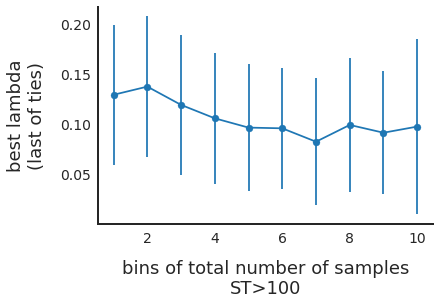

In [96]:
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]

#bin by equal #samples per bin
numbins = 10
binsize = len(numsamples_sorted)//numbins
print(len(numsamples_sorted)%numbins)
mean = []
sd = []
startindex = 0
for i in range(numbins):
    if i == numbins-1: #last bin
        currint = hyperp_sorted[startindex:len(hyperp_sorted)]
    else:
        currint = hyperp_sorted[startindex:startindex+binsize]

    mean.append(np.mean(currint))
    sd.append(np.std(currint))
    startindex = startindex+binsize

plt.scatter(range(1,numbins+1), mean)
plt.errorbar(x=range(1,numbins+1), y=mean, yerr=sd)
plt.xlabel("bins of total number of samples\nST>100")
plt.ylabel("best lambda\n(last of ties)")
plt.savefig("040121_2.pdf", bbox_inches='tight')

# ABA, areas > 150

In [97]:
bestparams = pd.read_csv("/home/slu/spatial/data/hyperparamCV_lasso/ABA_bestparams_032421.csv", sep=',')
bestparams = bestparams.set_index(bestparams.columns)
bestscore = pd.read_csv("/home/slu/spatial/data/hyperparamCV_lasso/ABA_bestscore_032421.csv")
meantestscore = np.load('/home/slu/spatial/data/hyperparamCV_lasso/ABA_meantestscore_032421.npy',allow_pickle='TRUE').item()
teststd = np.load('/home/slu/spatial/data/hyperparamCV_lasso/ABA_meanteststd_032421.npy',allow_pickle='TRUE').item()

In [98]:
bestparams.head()

,632,821,733,381,26,194,7,943,465,146,...,10723,10683,10713,262,10687,952,854,284,276,202
632,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
821,0,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
733,0,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
381,0,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
26,0,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [51]:
histdata = bestparams.values[np.triu_indices_from(bestparams,k=1)]
#uniq, counts = np.unique(histdata, return_counts=True)
#plt.bar(x=uniq, height=counts)

Text(0, 0.5, 'number of brain area\ncomparisons')

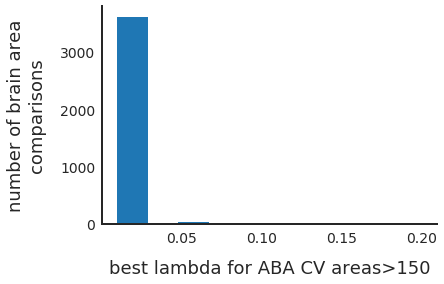

In [56]:
plt.hist(histdata)
plt.xlabel("best lambda for ABA CV areas>150")
plt.ylabel("number of brain area\ncomparisons")
#plt.savefig('032521_1.pdf', bbox_inches='tight')

In [57]:
meantestscore['0,1']

array([1. , 1. , 1. , 1. , 0.5, 0.5])

In [62]:
#meantestscore

In [99]:
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"

In [100]:
def read_data():
    """read in all datasets needed using pandas"""
    metabrain = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
    voxbrain = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
    propontvox = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
    #geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')	

    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return metabrain, voxbrain, propontvox, ontology


In [101]:
#pre-processing
metabrain, voxbrain, propontvox, ontology = read_data()
propontvox = filterproponto(propontvox)
#get leaf areas only
leaves = getleaves(propontvox,ontology)
leafpropontvox = propontvox.loc[metabrain.ids.isin(leaves),leaves] #subset propontvox for leaf areas
leafvoxbrain = voxbrain.loc[metabrain.ids.isin(leaves),:] #subset voxbrain for voxels from leaves

#subset for sufficient samples size for hyperparameter selection
leafsizes = leafpropontvox.sum()
#plt.hist(leafsizes, bins=100)
#plt.xlabel("leaf brain area sizes ABA")
#plt.ylabel("number of brain areas")
#plt.savefig("032321.pdf", bbox_inches='tight')
#filter propogated ontology for brain areas with X number of samples min
leafsizes_sub = leafsizes[leafsizes>150]  #139 areas
leafpropontvox_sub = leafpropontvox.loc[:,leafsizes_sub.index]
#remove areas (rows) from propogated ontology that don't have any samples
rowsum = leafpropontvox_sub.sum(axis=1)
leafpropontvox_sub = leafpropontvox_sub.loc[rowsum > 0, :]
#index samples for rows to match porp ont
leafvoxbrain_sub = leafvoxbrain.loc[rowsum > 0, :]
print(len(leafsizes_sub))
print(leafvoxbrain_sub.shape)
print(leafpropontvox_sub.shape)

86
(28170, 19934)
(28170, 86)


In [102]:
numsamples = pd.DataFrame(index=list(bestparams), columns=list(bestparams))
numsamples = numsamples.fillna(0)

areas = list(bestparams)
#for each column, brain area
for i in range(bestparams.shape[1]):
    #for each row in each column
    for j in range(i+1,bestparams.shape[1]): #upper triangular!
        area1 = areas[i]
        area2 = areas[j]
        numsamples.iloc[i,j] = leafsizes[area1] + leafsizes[area2]

In [103]:
numsamples = numsamples.values[np.triu_indices_from(numsamples,k=1)]

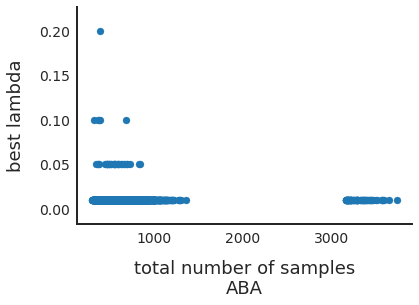

In [63]:
#alpha as a function of brain area size
plt.scatter(numsamples,histdata)
plt.xlabel("total number of samples\nABA")
plt.ylabel("best lambda")
#plt.savefig('032521_2.pdf', bbox_inches='tight')
plt.show()

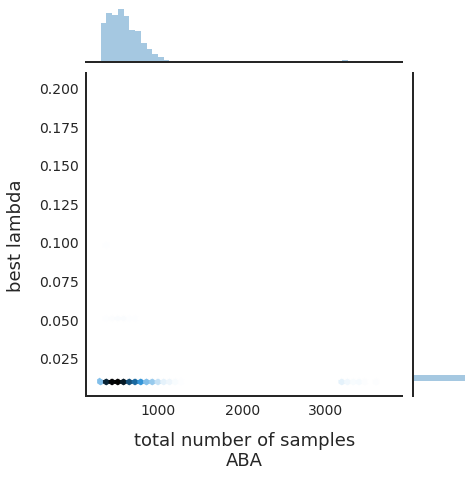

In [64]:
sns.jointplot(numsamples, histdata, kind='hex').set_axis_labels("total number of samples\nABA","best lambda")
#plt.savefig('032521_3.pdf', bbox_inches='tight')

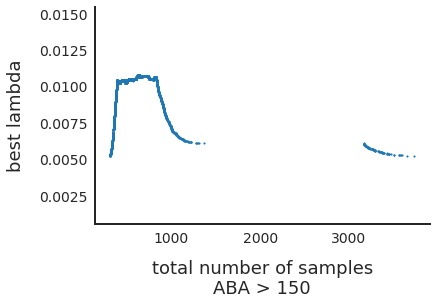

In [66]:
#define 'sliding window' as a uniform dist
uniform = [1/1000] * 1000
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]
#convolve
hyperp_conv = np.convolve(hyperp_sorted, uniform, mode='same')

plt.scatter(numsamples_sorted, hyperp_conv, s=3, rasterized=True)
plt.xlabel("total number of samples\nABA > 150")
plt.ylabel("best lambda")
plt.savefig("033121_5.pdf", bbox_inches='tight')
plt.show()

55


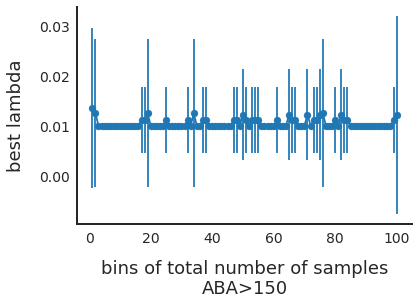

In [70]:
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]

#bin by equal #samples per bin
numbins = 100
binsize = len(numsamples_sorted)//numbins
print(len(numsamples_sorted)%numbins)
mean = []
sd = []
startindex = 0
for i in range(numbins):
    if i == numbins-1: #last bin
        currint = hyperp_sorted[startindex:len(hyperp_sorted)]
    else:
        currint = hyperp_sorted[startindex:startindex+binsize]

    mean.append(np.mean(currint))
    sd.append(np.std(currint))
    startindex = startindex+binsize

plt.scatter(range(1,numbins+1), mean, rasterized=True)
plt.errorbar(x=range(1,numbins+1), y=mean, yerr=sd)
plt.xlabel("bins of total number of samples\nABA>150")
plt.ylabel("best lambda")
plt.savefig("033121_6.pdf", bbox_inches='tight')

looking into ties

In [104]:
lastofties = pd.DataFrame(index=list(bestparams), columns=list(bestparams))
lastofties = lastofties.fillna(0)

alphas = [0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
#for each column, brain area
for i in range(bestparams.shape[1]):
    #for each row in each column
    for j in range(i+1,bestparams.shape[1]): #upper triangular!
        currkey = "%d,%d" %(i,j)
        currscores = meantestscore[currkey]
        bestindex = 0
        bestscore = -1
        for k in range(len(currscores)):
            if currscores[k] >= bestscore:
                bestscore = currscores[k]
                bestindex = k
        lastofties.iloc[i,j] = alphas[bestindex]

In [105]:
histdata = lastofties.values[np.triu_indices_from(lastofties,k=1)]

5


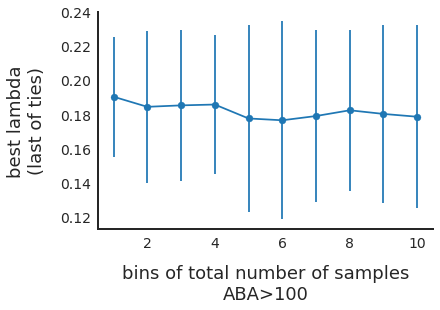

In [106]:
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]

#bin by equal #samples per bin
numbins = 10
binsize = len(numsamples_sorted)//numbins
print(len(numsamples_sorted)%numbins)
mean = []
sd = []
startindex = 0
for i in range(numbins):
    if i == numbins-1: #last bin
        currint = hyperp_sorted[startindex:len(hyperp_sorted)]
    else:
        currint = hyperp_sorted[startindex:startindex+binsize]

    mean.append(np.mean(currint))
    sd.append(np.std(currint))
    startindex = startindex+binsize

plt.scatter(range(1,numbins+1), mean)
plt.errorbar(x=range(1,numbins+1), y=mean, yerr=sd)
plt.xlabel("bins of total number of samples\nABA>100")
plt.ylabel("best lambda\n(last of ties)")
plt.savefig("040121_3.pdf", bbox_inches='tight')

# ABA, areas > 100

In [6]:
bestparams = pd.read_csv("/home/slu/spatial/data/hyperparamCV_lasso/ABA_bestparams_032521.csv", sep=',')
bestparams = bestparams.set_index(bestparams.columns)
bestscore = pd.read_csv("/home/slu/spatial/data/hyperparamCV_lasso/ABA_bestscore_032521.csv")
meantestscore = np.load('/home/slu/spatial/data/hyperparamCV_lasso/ABA_meantestscore_032521.npy',allow_pickle='TRUE').item()
teststd = np.load('/home/slu/spatial/data/hyperparamCV_lasso/ABA_meanteststd_032521.npy',allow_pickle='TRUE').item()

In [7]:
bestparams.head()
bestparams.shape

(139, 139)

In [73]:
histdata = bestparams.values[np.triu_indices_from(bestparams,k=1)]
#uniq, counts = np.unique(histdata, return_counts=True)
#plt.bar(x=uniq, height=counts)

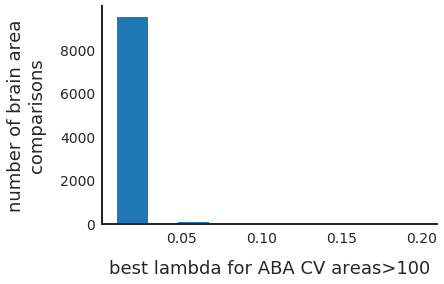

In [74]:
plt.hist(histdata)
plt.xlabel("best lambda for ABA CV areas>100")
plt.ylabel("number of brain area\ncomparisons")
plt.savefig('033121_7.pdf', bbox_inches='tight')

In [75]:
meantestscore['0,1']

array([1. , 1. , 1. , 1. , 0.5, 0.5])

In [62]:
#meantestscore

In [65]:
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"

In [66]:
def read_data():
    """read in all datasets needed using pandas"""
    metabrain = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
    voxbrain = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
    propontvox = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
    #geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')	

    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return metabrain, voxbrain, propontvox, ontology


In [67]:
#pre-processing
metabrain, voxbrain, propontvox, ontology = read_data()
propontvox = filterproponto(propontvox)
#get leaf areas only
leaves = getleaves(propontvox,ontology)
leafpropontvox = propontvox.loc[metabrain.ids.isin(leaves),leaves] #subset propontvox for leaf areas
leafvoxbrain = voxbrain.loc[metabrain.ids.isin(leaves),:] #subset voxbrain for voxels from leaves

#subset for sufficient samples size for hyperparameter selection
leafsizes = leafpropontvox.sum()
#plt.hist(leafsizes, bins=100)
#plt.xlabel("leaf brain area sizes ABA")
#plt.ylabel("number of brain areas")
#plt.savefig("032321.pdf", bbox_inches='tight')
#filter propogated ontology for brain areas with X number of samples min
leafsizes_sub = leafsizes[leafsizes>100]  #139 areas
leafpropontvox_sub = leafpropontvox.loc[:,leafsizes_sub.index]
#remove areas (rows) from propogated ontology that don't have any samples
rowsum = leafpropontvox_sub.sum(axis=1)
leafpropontvox_sub = leafpropontvox_sub.loc[rowsum > 0, :]
#index samples for rows to match porp ont
leafvoxbrain_sub = leafvoxbrain.loc[rowsum > 0, :]
print(len(leafsizes_sub))
print(leafvoxbrain_sub.shape)
print(leafpropontvox_sub.shape)

139
(34661, 19934)
(34661, 139)


In [68]:
numsamples = pd.DataFrame(index=list(bestparams), columns=list(bestparams))
numsamples = numsamples.fillna(0)

areas = list(bestparams)
#for each column, brain area
for i in range(bestparams.shape[1]):
    #for each row in each column
    for j in range(i+1,bestparams.shape[1]): #upper triangular!
        area1 = areas[i]
        area2 = areas[j]
        numsamples.iloc[i,j] = leafsizes[area1] + leafsizes[area2]

In [69]:
numsamples = numsamples.values[np.triu_indices_from(numsamples,k=1)]

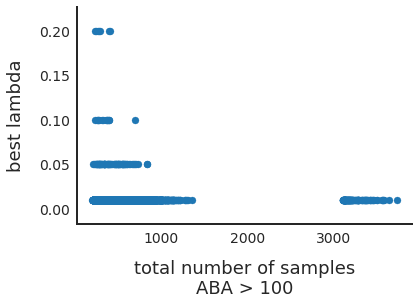

In [81]:
#alpha as a function of brain area size
plt.scatter(numsamples,histdata)
plt.xlabel("total number of samples\nABA > 100")
plt.ylabel("best lambda")
plt.savefig('033121_8.pdf', bbox_inches='tight')
plt.show()

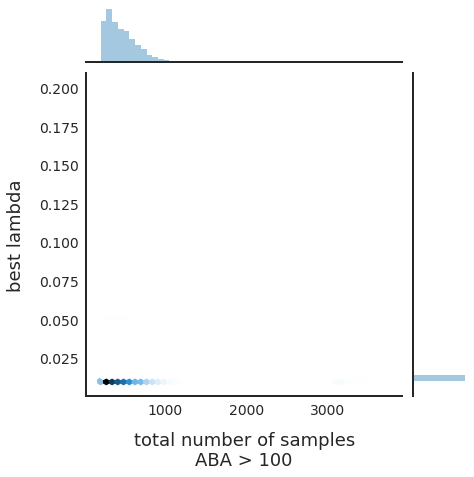

In [82]:
sns.jointplot(numsamples, histdata, kind='hex').set_axis_labels("total number of samples\nABA > 100","best lambda")
plt.savefig('033121_9.pdf', bbox_inches='tight')

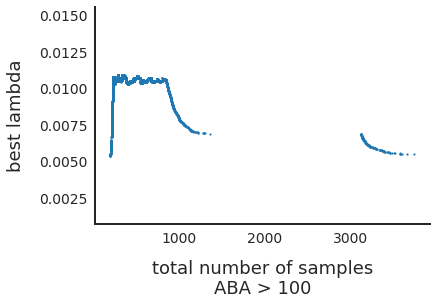

In [85]:
#define 'sliding window' as a uniform dist
uniform = [1/1000] * 1000
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]
#convolve
hyperp_conv = np.convolve(hyperp_sorted, uniform, mode='same')

plt.scatter(numsamples_sorted, hyperp_conv, s=3, rasterized=True)
plt.xlabel("total number of samples\nABA > 100")
plt.ylabel("best lambda")
plt.savefig("033121_10.pdf", bbox_inches='tight')
plt.show()

41


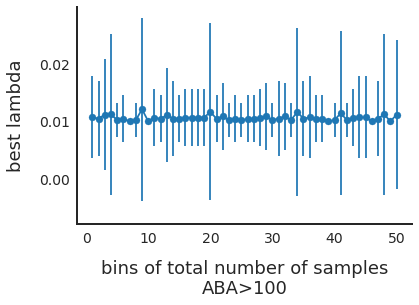

In [87]:
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]

#bin by equal #samples per bin
numbins = 50
binsize = len(numsamples_sorted)//numbins
print(len(numsamples_sorted)%numbins)
mean = []
sd = []
startindex = 0
for i in range(numbins):
    if i == numbins-1: #last bin
        currint = hyperp_sorted[startindex:len(hyperp_sorted)]
    else:
        currint = hyperp_sorted[startindex:startindex+binsize]

    mean.append(np.mean(currint))
    sd.append(np.std(currint))
    startindex = startindex+binsize

plt.scatter(range(1,numbins+1), mean, rasterized=True)
plt.errorbar(x=range(1,numbins+1), y=mean, yerr=sd)
plt.xlabel("bins of total number of samples\nABA>100")
plt.ylabel("best lambda")
plt.savefig("033121_11.pdf", bbox_inches='tight')

looking into ties

In [70]:
lastofties = pd.DataFrame(index=list(bestparams), columns=list(bestparams))
lastofties = lastofties.fillna(0)

alphas = [0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
#for each column, brain area
for i in range(bestparams.shape[1]):
    #for each row in each column
    for j in range(i+1,bestparams.shape[1]): #upper triangular!
        currkey = "%d,%d" %(i,j)
        currscores = meantestscore[currkey]
        bestindex = 0
        bestscore = -1
        for k in range(len(currscores)):
            if currscores[k] >= bestscore:
                bestscore = currscores[k]
                bestindex = k
        lastofties.iloc[i,j] = alphas[bestindex]

In [71]:
histdata = lastofties.values[np.triu_indices_from(lastofties,k=1)]

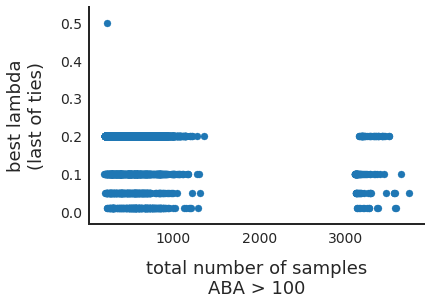

In [74]:
#alpha as a function of brain area size
plt.scatter(numsamples,histdata)
plt.xlabel("total number of samples\nABA > 100")
plt.ylabel("best lambda\n(last of ties)")
#plt.savefig('033121_8.pdf', bbox_inches='tight')
plt.show()

1


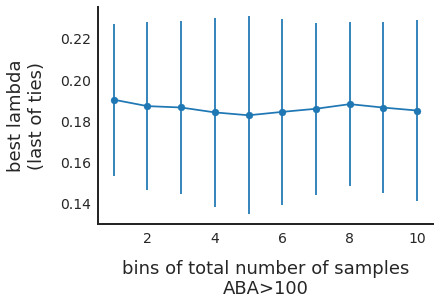

In [76]:
#sort both lists by total number of samples
numsamples_sorted = sorted(numsamples)
hyperp_sorted = [x for y, x in sorted(zip(numsamples_sorted, histdata))]

#bin by equal #samples per bin
numbins = 10
binsize = len(numsamples_sorted)//numbins
print(len(numsamples_sorted)%numbins)
mean = []
sd = []
startindex = 0
for i in range(numbins):
    if i == numbins-1: #last bin
        currint = hyperp_sorted[startindex:len(hyperp_sorted)]
    else:
        currint = hyperp_sorted[startindex:startindex+binsize]

    mean.append(np.mean(currint))
    sd.append(np.std(currint))
    startindex = startindex+binsize

plt.scatter(range(1,numbins+1), mean)
plt.errorbar(x=range(1,numbins+1), y=mean, yerr=sd)
plt.xlabel("bins of total number of samples\nABA>100")
plt.ylabel("best lambda\n(last of ties)")
plt.savefig("040121_4.pdf", bbox_inches='tight')